# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [86]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List
from heapq import heapify, heappop, heappush

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [87]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:

    df = pd.read_csv(path_to_csv)
    df = df.sample(frac=1).reset_index(drop=True)
    X = df.drop(["label"], axis=1).to_numpy()
    y = np.multiply((df[["label"]] == "M").to_numpy(),1).reshape(-1)
    return (X, y)
    raise NotImplementedError()


def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:

    df = pd.read_csv(path_to_csv)
    df = df.sample(frac=1).reset_index(drop=True)
    X = df.drop(["label"], axis=1).to_numpy()
    y = df[["label"]].to_numpy().reshape(-1)
    return (X, y)
    raise NotImplementedError()

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [88]:
def train_test_split(X: np.array, Y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    
    sliced=int(np.floor(Y.shape[0]*ratio))
    X_train, X_test = X[:sliced,:], X[sliced:,:]
    Y_train, Y_test = Y[:sliced], Y[sliced:]
    return (X_train, Y_train, X_test, Y_test)
    raise NotImplementedError()
   

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [89]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    y_all = np.concatenate((y_pred,y_true))
    dict_all=dict.fromkeys(np.unique(y_all),0)
    dict_tp=dict_all.copy()
    dict_fp=dict_all.copy()
    dict_fn=dict_all.copy()
    count_acc=0
    
    for i in range(y_true.size):
        if y_pred[i]==y_true[i]:
            dict_tp[y_true[i]]+=1
            count_acc+=1
        else:
            dict_fp[y_pred[i]]+=1
            dict_fn[y_true[i]]+=1
            
    precision=np.array([])
    recall=np.array([])
    
    for i in range(len(dict_all)):
      if (dict_tp[list(dict_tp.keys())[i]]+dict_fp[list(dict_fp.keys())[i]])!=0:
        precision = np.append(precision, dict_tp[list(dict_tp.keys())[i]]/
                  (dict_tp[list(dict_tp.keys())[i]]+dict_fp[list(dict_fp.keys())[i]]))
      else:
        precision = np.append(precision,0)
      if (dict_tp[list(dict_tp.keys())[i]]+dict_fn[list(dict_fn.keys())[i]])!=0:
        recall = np.append(recall, dict_tp[list(dict_tp.keys())[i]]/
                  (dict_tp[list(dict_tp.keys())[i]]+dict_fn[list(dict_fn.keys())[i]]))
      else:
        recall = np.append(recall,0)
    accuracy=count_acc/y_true.size
    
    return (precision, recall, accuracy)
    raise NotImplementedError()

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [90]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)

    def plot(x, ys, ylabel, legend=True):
        plt.figure(figsize=(12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys) - 0.01, np.max(ys) + 0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()

    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [91]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(
                sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0)
                / positive_samples
            )
            fpr.append(
                sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0)
                / (len(y_test) - positive_samples)
            )
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize=(7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [92]:
class KDNode:
        def __init__(self,  points,  med_index = None,  
                 med = None,  left=None,  right=None):
          
            self.points = points
            self.med_index = med_index
            self.med = med
            self.left = left
            self.right = right

def merge(A, B):
    i , j = 0 , 0
    ans = []
    while i < len(A) and j < len(B):
        if A[i] <= B[j]:
            ans.append(A[i])
            i += 1
        else:
            ans.append(B[j])
            j += 1
    ans += A[i:]
    ans += B[j:]
    return ans
            
class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        
        self.X = X
        self.leaf_size = max(self.X.shape[1], leaf_size)
        self.dist = (lambda x,y: np.sqrt(np.sum((x - y) ** 2, axis=1)))
        self.root = self.build_tree(np.arange(self.X.shape[0]), 0)

    def build_tree(self, points, med_index):
        if points.shape[0] < self.leaf_size:
            return KDNode(points)

        med = np.median(self.X[points, med_index])
        index_left = np.intersect1d(points, np.argwhere(self.X[:, med_index] <= med))
        index_right = np.intersect1d(points, np.argwhere(self.X[:, med_index] > med))

        left = self.build_tree(index_left, (med_index + 1) % self.X.shape[1])
        right = self.build_tree(index_right, (med_index + 1) % self.X.shape[1])

        return KDNode(points, med_index, med, left, right)

    def find_points(self, X: np.array, root: KDNode, max_d: float = np.Inf, k: int = 1):

        nearest, nearest_left, nearest_right = [], [], []

        if root.left is None or root.points.shape[0] <= k:
            nearest = list(zip(self.dist(X, self.X[root.points]), root.points))
            nearest.sort()
            return nearest[:k]
        if X[root.med_index] <= root.med:
            nearest_left = self.find_points(X, root.left, max_d, k)
            if len(nearest_left) < k:
                nearest_right = self.find_points(X, root.right, max_d, k)
            elif np.abs(X[root.med_index] - root.med) < nearest_left[-1][0]:
                nearest_right = self.find_points(X, root.right, nearest_left[-1][0], k)
            return merge(nearest_left, nearest_right)[:k]
        else:
            nearest_right = self.find_points(X, root.right, max_d, k)
            if len(nearest_right) < k:
                nearest_left = self.find_points(X, root.left, max_d, k)
            elif np.abs(X[root.med_index] - root.med) < nearest_right[-1][0]:
                nearest_left = self.find_points(X, root.left, nearest_right[-1][0], k)
            return merge(nearest_right, nearest_left)[:k]
    

    def query(self, X: np.array, k: int = 1) -> np.array:
        ans = []
        for x in X:
            nearest = self.find_points(x, self.root, k=k)
            nearest = list(map(lambda x: int(x[1]), nearest))
            ans.append(nearest)
        return np.array(ans)
        raise NotImplementedError()

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [93]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [94]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size

    def fit(self, X: np.array, y: np.array) -> NoReturn:
      
        self.X = X
        self.y = y
        self.labels = np.unique(y)
        self.labels.sort()
        self.tree = KDTree(self.X, self.leaf_size)

    def predict_proba(self, X: np.array) -> List[np.array]:

        predict_k_labels = self.y[self.tree.query(X, k=self.n_neighbors)]

        proba = np.zeros((X.shape[0], self.labels.shape[0]))
        for i, c in enumerate(self.labels):
            proba[:, i] += (predict_k_labels == c).sum(1)
        proba /= self.n_neighbors
        return proba
        raise NotImplementedError()

    def predict(self, X: np.array) -> np.array:
        return np.argmax(self.predict_proba(X), axis=1)
        raise NotImplementedError()

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

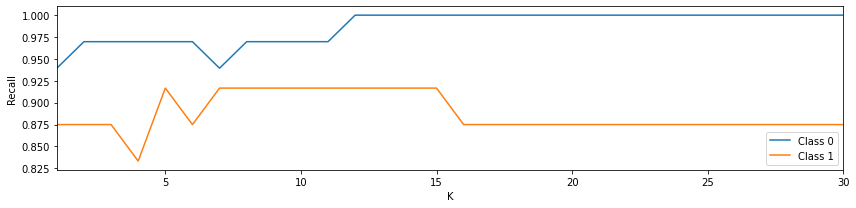

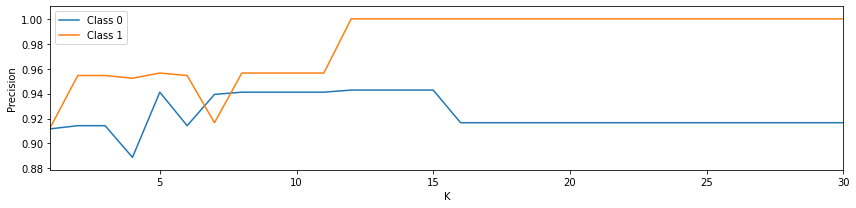

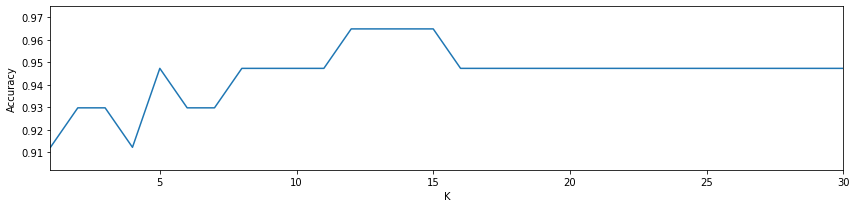

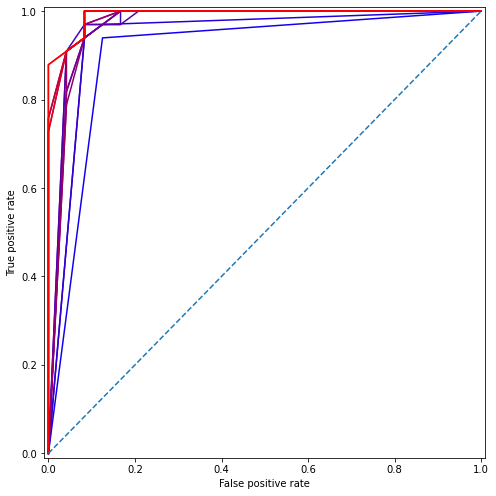

CPU times: user 4.29 s, sys: 447 ms, total: 4.74 s
Wall time: 4.25 s


In [97]:
%%time

X, y = read_cancer_dataset("/content/gdrive/My Drive/cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=15)

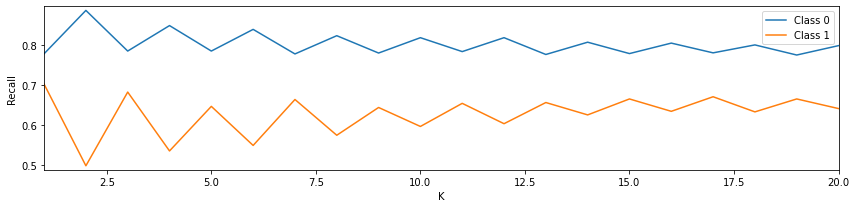

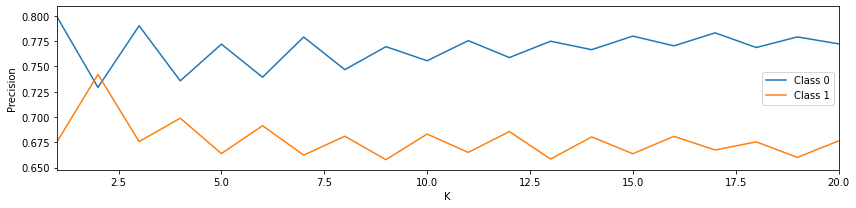

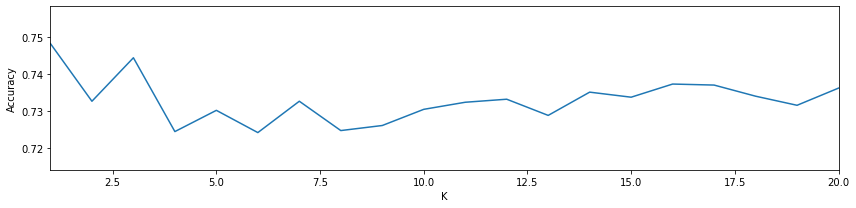

In [ ]:
%%time
X, y = read_spam_dataset("/content/gdrive/My Drive/spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.2)


plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)